# Implementation of MSM

Start by copying the code implementing consumption-savings model from  `lab5/egm.ipynb`, and make the following modifications:
- move `solve_egm` into the `deaton` model class to make it a class method
    * make sure to adjust the indent in each line!
    * effectively no change to the code is needed, only perhaps change first argument from *model* to *self*, yet the exact word used does not matter, so it should work as is
- also move `solve_plot`, `euler_residual`, `accuracy`, and `simulator` into the class in exactly the same way


In [ ]:
# Copy the modified consumption-savings model here

Deaton model with beta=0.900, sigma=0.500, gross return=1.050
Grids: state 100 points up to 10.0, quadrature 10 points
The model is not solved.
||||||||||||||||||||||||||

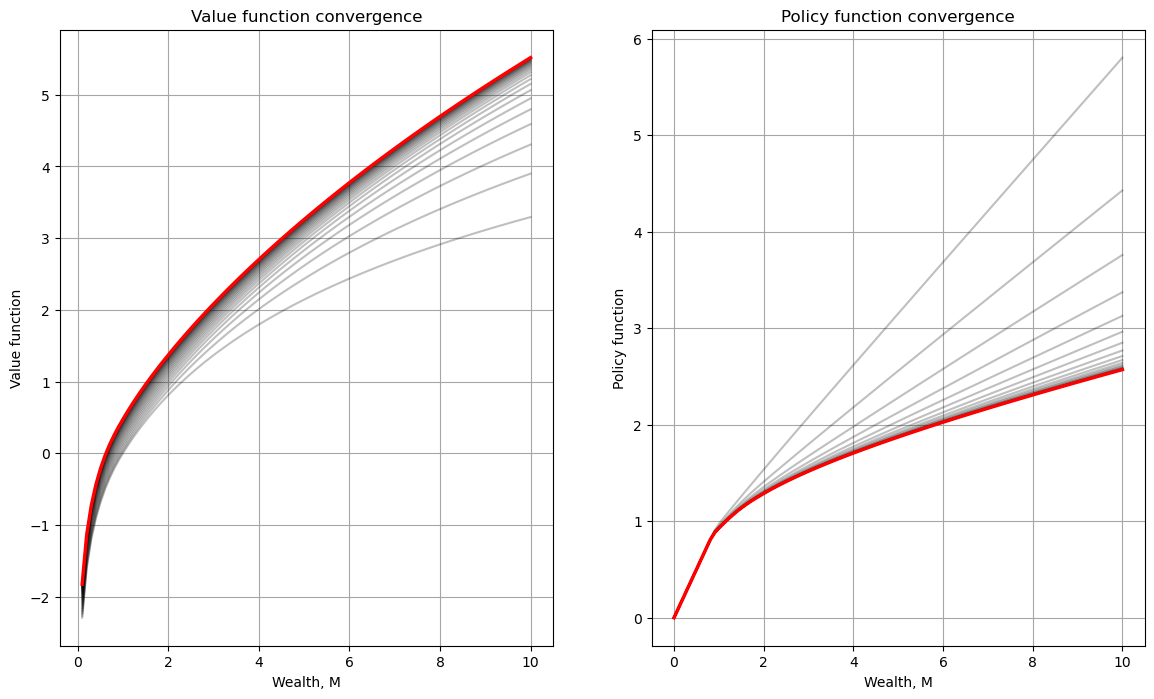

Average squared Euler residuals (egm) using 1000 points is 1.9393944785730416e-05


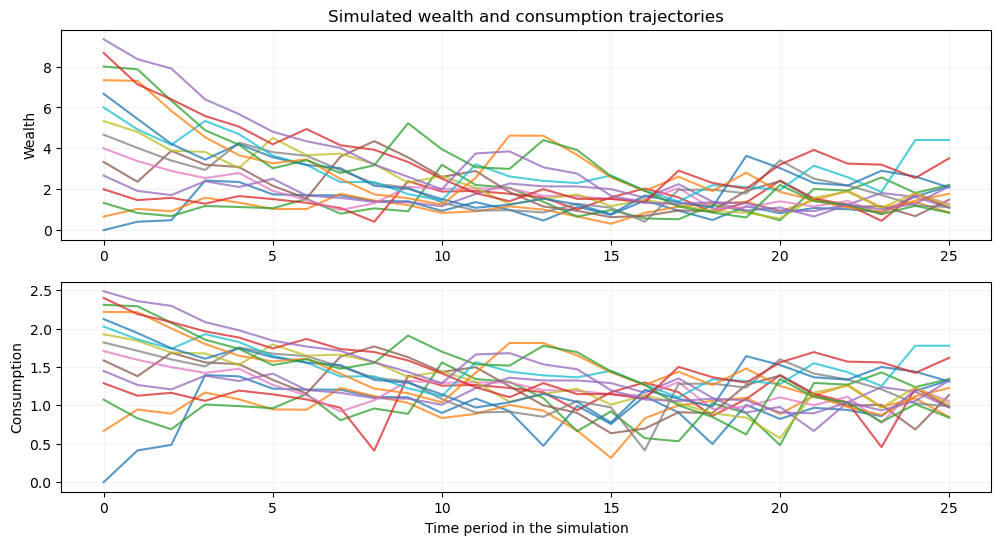

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import lognorm
# from scipy.optimize import minimize_scalar, brentq

class deaton():
    '''Implementation of the stochastic Deaton consumption-savings problem with random income.'''

    def __init__(self, Mbar=10,
                 ngrid=50, nquad=10,
                 interpolation='linear',
                 beta=.9, R=1.05, sigma=1.):
        '''Object creator for the stochastic consumption-savings model'''
        self.beta = beta        # Discount factor
        self.R = R              # Gross interest
        self.sigma = sigma      # Param in log-normal income distribution
        self.Mbar = Mbar        # Upper bound on wealth
        self.ngrid = ngrid      # Number of grid points in the state space
        self.nquad = nquad      # Number of quadrature points
        self.interpolation = interpolation  # type of interpolation, see below
        # state and choice space grids, as well as quadrature points and weights are set with setter functions below

    def __repr__(self):
        '''String representation for the model'''
        return 'Deaton model with beta={:1.3f}, sigma={:1.3f}, gross return={:1.3f}\nGrids: state {} points up to {:1.1f}, quadrature {} points\nThe model is {}solved.'\
               .format(self.beta,self.sigma,self.R,self.ngrid,self.Mbar,self.nquad,'' if hasattr(self,'solution') else 'not ')

    @property
    def ngrid(self):
        '''Property getter for the ngrid parameter'''
        return self.__ngrid

    @ngrid.setter
    def ngrid(self,ngrid):
        '''Property setter for the ngrid parameter'''
        self.__ngrid = ngrid
        epsilon = np.finfo(float).eps # smallest positive float number difference
        self.grid = np.linspace(epsilon,self.Mbar,ngrid) # grid for state space

    @property
    def sigma(self):
        '''Property getter for the sigma parameter'''
        return self.__sigma

    @sigma.setter
    def sigma(self,sigma):
        '''Property setter for the sigma parameter'''
        self.__sigma = sigma
        self.__quadrature_setup()  # update quadrature points and weights

    @property
    def nquad(self):
        '''Property getter for the number of quadrature points'''
        return self.__nquad

    @nquad.setter
    def nquad(self,nquad):
        '''Property setter for the number of quadrature points'''
        self.__nquad = nquad
        self.__quadrature_setup()  # update quadrature points and weights

    def __quadrature_setup(self):
        '''Internal function to set up quadrature points and weights,
        depends on sigma and nquad, therefore called from the property setters
        '''
        try:
            # quadrature points and weights for log-normal distribution
            self.quadp,self.quadw = np.polynomial.legendre.leggauss(self.__nquad) # Gauss-Legendre for [-1,1]
            self.quadp = (self.quadp+1)/2 # rescale to [0,1]
            self.quadp = lognorm.ppf(self.quadp,self.__sigma) # inverse cdf
            self.quadw /= 2 # rescale weights as well
        except(AttributeError):
            # when __nquad or __sigma are not yet set
            pass

    def utility(self,c):
        '''Utility function'''
        return np.log(c)

    def marginal_utility(self,c):
        '''Marginal utility function'''
        return 1/c

    def inverse_marginal_utility(self,u):
        '''Marginal utility function'''
        return 1/u

    def next_period_wealth(self,M,c,y):
        '''Next period budget'''
        if self.nquad>1:
            return self.R*(M-c) + y  # next period wealth
        else:
            return self.R*(M-c) + np.zeros(shape=y.shape) # next period wealth without income

    def interp_func(self,x,f):
        '''Returns the interpolation function for given data'''
        if self.interpolation=='linear':
            return interpolate.interp1d(x,f,kind='slinear',fill_value="extrapolate")
        elif self.interpolation=='quadratic':
            return interpolate.interp1d(x,f,kind='quadratic',fill_value="extrapolate")
        elif self.interpolation=='cubic':
            return interpolate.interp1d(x,f,kind='cubic',fill_value="extrapolate")
        elif self.interpolation=='polynomial':
            p = np.polynomial.polynomial.polyfit(x,f,self.ngrid_state-1)
            return lambda x: np.polynomial.polynomial.polyval(x,p)
        else:
            print('Unknown interpolation type')
            return None

    def solve_egm (self,maxiter=500,tol=1e-4,callback=None):
        '''Solves the model using EGM (successive approximations of efficient Coleman-Reffet operator)
           Callback function is invoked at each iteration with keyword arguments.
        '''
        A = np.linspace(0,self.Mbar,self.ngrid)  # grid on savings
        interp = lambda x,f: interpolate.interp1d(x,f,kind='slinear',fill_value="extrapolate") # linear interpolation
        c0 = interp([0,self.Mbar],[0,self.Mbar]) # initial policy function
        V0 = self.utility(self.grid)
        for iter in range(maxiter):
            # EGM step
            M1 = self.next_period_wealth(A[:,np.newaxis],0,self.quadp[np.newaxis,:]) # matrix with A in axis=0, y/quadpoints in axis=1
            c1 = np.maximum(c0(M1),self.grid[0])         # value function at next period wealth, 3-dim array
            mu = self.marginal_utility(c1)               # marginal utility in the RHS
            RHS = self.beta*self.R*np.dot(mu,self.quadw) # RHS of Euler equation
            c = np.empty(self.ngrid+1,dtype=float)
            M = np.empty(self.ngrid+1,dtype=float)
            c[0] = M[0] = 0.
            c[1:] = self.inverse_marginal_utility(RHS)    # current period consumption (vector)
            M[1:] = c[1:] + A                             # vector of endogenous points on M
            c1 = interp(M,c)                              # updated policy function
            c1grid = c1(self.grid)                        # vector representation of policy function
            # matrix of next period wealth, states in axis=0, quadpoint in axis=1
            M1 = self.next_period_wealth(self.grid[:,np.newaxis],c1grid[:,np.newaxis],self.quadp[np.newaxis,:])
            interfunc = self.interp_func(self.grid,V0)    # interpolcation for the value function
            V  = interfunc(M1)                            # value function at next period wealth
            EV = np.dot(V,self.quadw)                     # expected value function, vector
            V1 = self.utility(c1grid) + self.beta*EV      # maximand of Bellman equation, column-vector
            err = np.amax(np.abs(c1grid-c0(self.grid)))
            if callback: callback(iter=iter,model=self,value=V1,policy=c1grid,err=err) # callback for making plots
            if err < tol:
                break  # converged!
            c0,V0 = c1,V1  # prepare for the next iteration
        else:  # when iter went up to maxiter
            raise RuntimeError('No convergence: maximum number of iterations achieved!')
        self.solution = {'value':V1,'policy':c1grid,'solver':'egm'}  # save the model solution to the object
        return V1,c1grid

    def solve_plot(self,**kvarg):
        '''Illustrate solution
           Inputs: solver (string), and any inputs to the solver
        '''
        solver_func = self.solve_egm
        fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
        ax1.grid(visible=True, which='both', color='0.65', linestyle='-')
        ax2.grid(visible=True, which='both', color='0.65', linestyle='-')
        ax1.set_title('Value function convergence')
        ax2.set_title('Policy function convergence')
        ax1.set_xlabel('Wealth, M')
        ax2.set_xlabel('Wealth, M')
        ax1.set_ylabel('Value function')
        ax2.set_ylabel('Policy function')
        def callback(**kwargs):
            print('|',end='')
            grid = kwargs['model'].grid
            v = kwargs['value']
            c = kwargs['policy']
            ax1.plot(grid[1:],v[1:],color='k',alpha=0.25)
            ax2.plot(grid,c,color='k',alpha=0.25)
        V,c = solver_func(callback=callback,**kvarg)
        # add solutions
        ax1.plot(self.grid[1:],V[1:],color='r',linewidth=2.5)
        ax2.plot(self.grid,c,color='r',linewidth=2.5)
        plt.show()
        return V,c
    
    def euler_residual(self,c,M,policy):
        '''Computes the Euler residuals for a given points (M,c), and
           given policy function that enters into the RHS
           Argument policy is interpolation function for the policy
        '''
        # assume that c and M are either scalars or 1-dim arrays of the same size
        if isinstance(c,np.ndarray):
            c0,M0 = c[:,np.newaxis],M[:,np.newaxis]  # axis 0: choices and states
            y = self.quadp[np.newaxis,:]             # axis 1: quadrature points
        else:
            c0,M0 = c,M
            y = self.quadp                           # 1-dim array of quadrature points
        M1 = self.next_period_wealth(M0,c0,y)        # 1-dim or 2-dim array with quad point in last dimension
        c1 = np.maximum(policy(M1),self.grid[0])     # value function at next period wealth, 3-dim array
        mu = self.marginal_utility(c1)               # marginal utility in the RHS
        RHS = self.beta*self.R*np.dot(mu,self.quadw) # RHS of Euler equation
        LHS = self.marginal_utility(c)
        return LHS-RHS

    def accuracy(self,dense_grid_factor=10,verbose=False):
        '''Compute the average squared Euler residuals for the saved solution'''
        assert hasattr(self,'solution'), 'Need to solve the model to compute the accuracy measure!'
        grid = np.linspace(self.grid[0],self.Mbar,self.ngrid*dense_grid_factor) # dense grid for state space
        inter = self.interp_func(self.grid,self.solution['policy'])  # interpolation function for policy function
        c = inter(grid)  # consumption on the dense grid
        er = self.euler_residual(c=c,M=grid,policy=inter)
        er = er[np.logical_not(np.isclose(c,grid,atol=1e-10))]  # disregard corner solutions
        acc = np.mean(er**2)
        if verbose:
            print('Average squared Euler residuals ({}) using {} points is {}'.format(
                self.solution['solver'],self.ngrid*dense_grid_factor,acc))
        else:
            return acc

    def simulator(self,init_wealth=1,T=10,seed=None,plot=True):
        '''Simulation of the model for given number of periods from given initial conditions'''
        assert hasattr(self,'solution'), 'Need to solve the model before simulating!'
        if seed!=None:
            np.random.seed(seed)  # fix the seed if needed
        init_wealth = np.asarray(init_wealth).ravel()  # flat np array of initial wealth
        N = init_wealth.size  # number of trajectories to simulate
        sim = {'M':np.empty((N,T+1)),'c':np.empty((N,T+1))}
        sim['M'][:,0] = init_wealth  # initial wealth in the first column
        inter = self.interp_func(self.grid,self.solution['policy'])  # interpolation function for policy function
        for t in range(T+1):
            sim['c'][:,t] = inter(sim['M'][:,t])  # optimal consumption in period t
            if t<T:
                y = lognorm.rvs(self.sigma,size=N) # draw random income
                sim['M'][:,t+1] = self.next_period_wealth(sim['M'][:,t],sim['c'][:,t],y) # next period wealth
        if plot:
            fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
            ax1.set_title('Simulated wealth and consumption trajectories')
            ax1.set_ylabel('Wealth')
            ax2.set_ylabel('Consumption')
            ax2.set_xlabel('Time period in the simulation')
            for ax in (ax1,ax2):
                ax.grid(visible=True, which='both', color='0.95', linestyle='-')
            for i in range(N):
                ax1.plot(sim['M'][i,:],alpha=0.75)
                ax2.plot(sim['c'][i,:],alpha=0.75)
            plt.show()
        return sim # return simulated data

# when the module is run directly
if __name__ == "__main__":
    m = deaton(ngrid=100,sigma=.5,nquad=10)
    print(m)
    iw=m.Mbar*np.arange(15)/15

    v,c = m.solve_plot()
    m.accuracy(verbose=True)
    sims = m.simulator(init_wealth=iw,T=25,seed=2020)



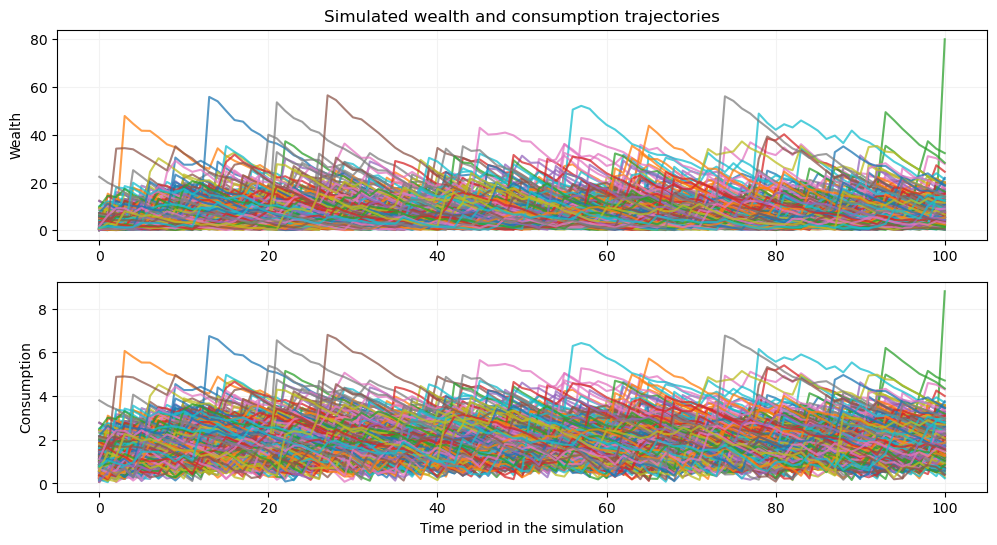

In [20]:
# Simulate a dataset that will be used for estimation
# (and check that the model code is working correctly)
model = deaton(beta=0.92,Mbar=50,ngrid=100)
model.solve_egm()
np.random.seed(14325)      # fix seed for initial draws
Nobs = 500 # number of observations to simulate
nT = 100 # number of time periods to simulate
init_wealth = np.exp(np.random.randn(Nobs)) # draw initial wealth
np.random.seed(15920) # fix seed for simulations
data = model.simulator(init_wealth=init_wealth,T=nT)
data_wealth = data['M']

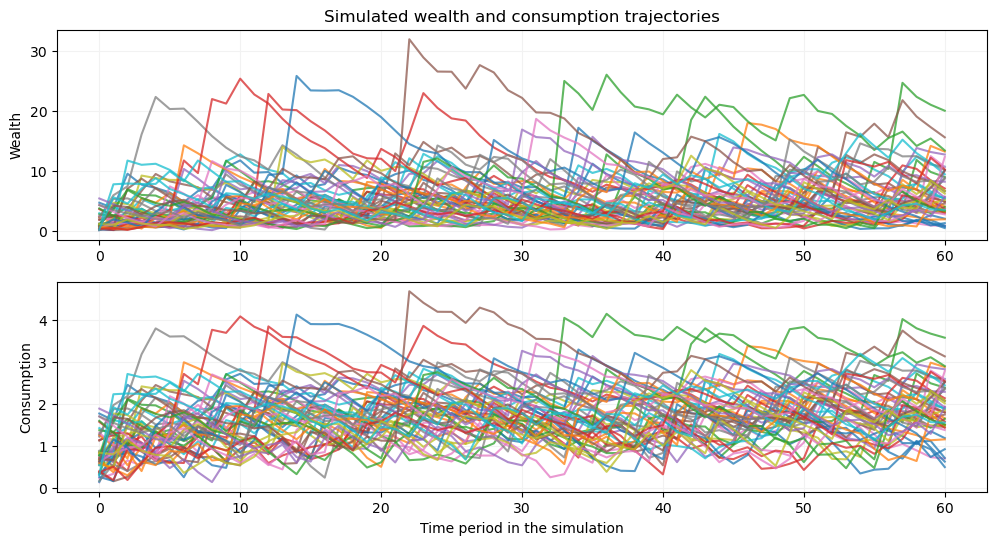

In [ ]:
# Simulate a dataset that will be used for estimation
# (and check that the model code is working correctly)
model = deaton(beta=0.92,Mbar=50,ngrid=100)
model.solve_egm()
np.random.seed(14325)      # fix seed for initial draws
Nobs = ??? # number of observations to simulate
nT = ??? # number of time periods to simulate
init_wealth = np.exp(np.random.randn(Nobs)) # draw initial wealth
np.random.seed(15920) # fix seed for simulations
data = model.simulator(init_wealth=init_wealth,T=nT)
data_wealth = data['M']

In [ ]:
def moments_function(data, tail=100):
  '''Computes moments from
       the tail of the given time series (from last axis)
       Returns two vectors with moments computed at individual level
    '''
  d = data.ndim - 1     # last dimension
  mean = np.mean(data[:, -tail:], axis=d)
  std = np.std(data[:, -tail:], axis=d)
  return mean, std

In [ ]:
def moments_function(data, tail=10):
  '''Computes moments from
       the tail of the given time series (from last axis)
       Returns two vectors with moments computed at individual level
    '''
  d = data.ndim - 1     # last dimension
  mean = np.mean(data[:, -tail:], axis=d)
  std = np.std(data[:, -tail:], axis=d)
  ??? add more moments ???
  return mean, std

In [22]:
# Data moments
# NOTE: adjust the code according to the moment generating function!
print('Number of observed individuals: ',data_wealth.shape[0],sep=' ')
print('Number of observed time periods:',data_wealth.shape[1],sep=' ')
data_moment1, data_moment2 = moments_function(data_wealth)  # data moments on individual level (of observed sample)
data_moment1_mean, data_moment1_std = np.mean(data_moment1), np.std(data_moment1)  # descriptive stats for empirical moments
data_moment2_mean, data_moment2_std = np.mean(data_moment2), np.std(data_moment2)
print(f'Moment 1 (mean wealth), mean and std.dev. over data sample  : {data_moment1_mean:.5f} ({data_moment1_std:.5f})')
print(f'Moment 2 (std of wealth), mean and std.dev. over data sample: {data_moment2_mean:.5f} ({data_moment2_std:.5f})')
data_moments_vec = np.array([data_moment1_mean, data_moment2_mean]) # vector of aggregated moments

Number of observed individuals:  500
Number of observed time periods: 101
Moment 1 (mean wealth), mean and std.dev. over data sample  : 6.07495 (4.35629)
Moment 2 (std of wealth), mean and std.dev. over data sample: 2.06454 (1.71303)


In [23]:
# MSM estimation exercise
model = deaton(beta=0.95,Mbar=50,ngrid=100)  # init the model
np.random.seed(214)                          # fix for initial wealth
init_wealth = np.exp(np.random.randn(250))   # draw initial wealth

def moment_conditions(theta,data_moments,seed=215):
    '''Moment conditions for MSM estimator,
       Inputs: parameter vector + vector of aggregated data moments
       Computed at the individual level.
       Random number generator seed fixed by default.
    '''
    model.beta = theta
    np.random.seed(seed) # must be fixed between calls!
    model.solve_egm(maxiter=1000)
    simdata = model.simulator(init_wealth=init_wealth,T=60,plot=False)
    # compute simulated moments
    sim_moment1, sim_moment2 = moments_function(simdata['M'])
    return sim_moment1 - data_moments[0], sim_moment2 - data_moments[1]

In [ ]:
# MSM estimation exercise
model = deaton(beta=0.95,Mbar=50,ngrid=100)  # init the model
np.random.seed(214)                          # fix for initial wealth
init_wealth = np.exp(np.random.randn(???))   # draw initial wealth

def moment_conditions(theta,data_moments,seed=215):
    '''Moment conditions for MSM estimator,
       Inputs: parameter vector + vector of aggregated data moments
       Computed at the individual level.
       Random number generator seed fixed by default.
    '''
    model.beta = theta
    np.random.seed(seed) # must be fixed between calls!
    model.solve_egm(maxiter=1000)
    simdata = model.simulator(init_wealth=init_wealth,T=60,plot=False)
    # compute simulated moments
    sim_moment1, sim_moment2 = ???
    # return moment conditions
    return ???

In [24]:
from scipy.optimize import minimize_scalar
from scipy.misc import derivative

def run_MSM(data_moments = data_moments_vec,                 # vector of data moments
            moment_conditions_function = moment_conditions,  # moment conditions generator
            W = None,                                        # weighting matrix
            bracket = [.85,.95],                             # approximate limits for the parameters
            plot = True):
    '''Run the MSM estimation
       Returns estimates and std.err. of estimates
    '''

    def mean_conditions(theta):
        '''Means of the moment conditions returned as a vector'''
        moms = moment_conditions_function(theta,data_moments)  # return a tuple
        moms = np.array(moms)  # convert to array, moments in axis=0, indiv in axis=1
        return np.mean(moms,axis=1)  # vector of means of moment conditions

    def criterion(theta,W):
        '''Criterion function for MSM estimator'''
        err = mean_conditions(theta)
        return err @ W @ err.T

    if W is None:
        # default weighting matrix = identity
        check = moment_conditions_function(1.0,data_moments)  # check how many moments
        W = np.eye(len(check))

    # minimize the criterion function
    res = minimize_scalar(criterion,method='Brent',args=(W),bracket=bracket,tol=1e-8)
    if not res.success:
        raise RuntimeError('Bellman continuous failed to find optimal consumption')
    theta_hat = res.x  # estimate

    # find out how many simulations were used
    moms = moment_conditions_function(theta_hat,data_moments)
    nsims = len(moms[0])  # will use in place of tau, assuming nobs=1 in the data

    D = derivative(mean_conditions,theta_hat,dx=1e-10)  # Jacobian of moment conditions
    DWD = D @ W @ D
    if np.isscalar(DWD):
        Sigma_hat = (1+1/nsims)/( DWD)  # using simple formula
        stderr = np.sqrt(Sigma_hat)
    else:
        Sigma_hat = (1+1/nsims)*np.linalg.inv( DWD)  # using simple formula
        stderr = np.sqrt(np.diag(Sigma_hat))
    CI = [theta_hat-1.96*stderr,theta_hat+1.96*stderr]  # 1.96 confidence interval

    print(f'MSM estimate       : {theta_hat:1.5f}')
    print(f'StdErr of estimate : {stderr:1.5f}')
    print(f'Confidence interval: ({CI[0]:1.5f},{CI[1]:1.5f})')

    if plot:
        # Plot criterion for visual inspection
        xd = np.linspace(bracket[0],bracket[1],50)
        yd = [criterion(b,W) for b in xd]
        fig,ax = plt.subplots(figsize=(12,8))
        ax.plot(xd,yd,color='r',label='MSM criterion function')
        y1,y2 = ax.get_ylim()
        ax.plot([theta_hat,theta_hat],[y1,y2],color='grey',label='MSM estimate')
        ax.fill_between(x=CI,y1=y1,y2=y2,color='grey',alpha=0.25,label='1.96 confidence interval')
        ax.legend()
        ax.set_title('Criterion function and MSM estimate');

    return theta_hat

/var/folders/5d/cjhpvdlx7lg8zt1ypw5fcyy40000gn/T/ipykernel_75257/265798644.py:39: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  D = derivative(mean_conditions,theta_hat,dx=1e-10)  # Jacobian of moment conditions


MSM estimate       : 0.92008
StdErr of estimate : 0.01097
Confidence interval: (0.89858,0.94157)


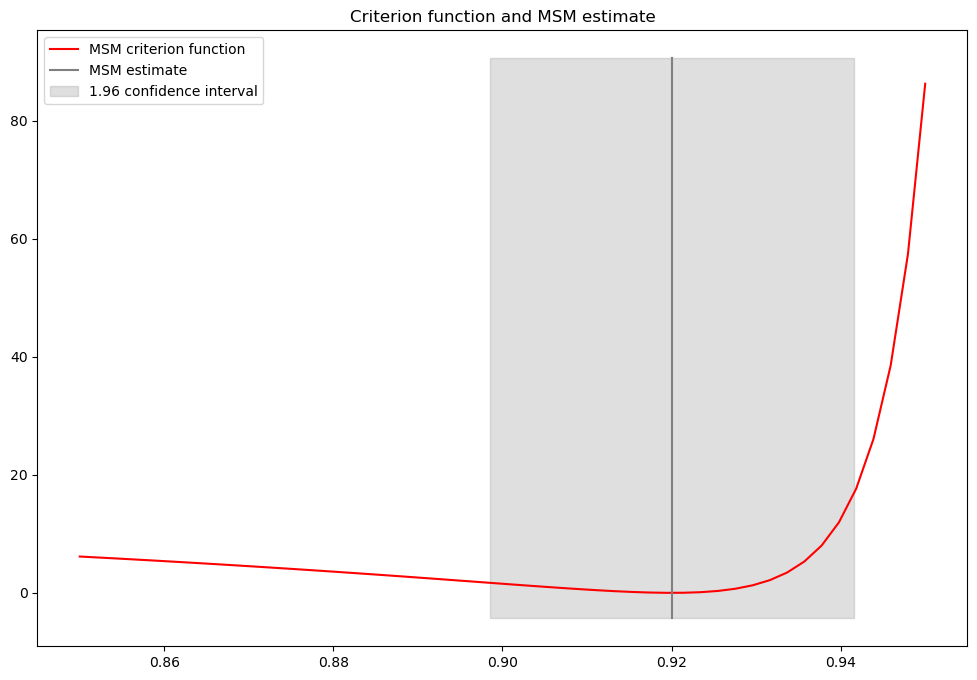

In [25]:
beta_hat = run_MSM()  # initial run with default identity weighting matrix

/var/folders/5d/cjhpvdlx7lg8zt1ypw5fcyy40000gn/T/ipykernel_75257/265798644.py:39: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  D = derivative(mean_conditions,theta_hat,dx=1e-10)  # Jacobian of moment conditions


MSM estimate       : 0.92112
StdErr of estimate : 0.03534
Confidence interval: (0.85187,0.99038)


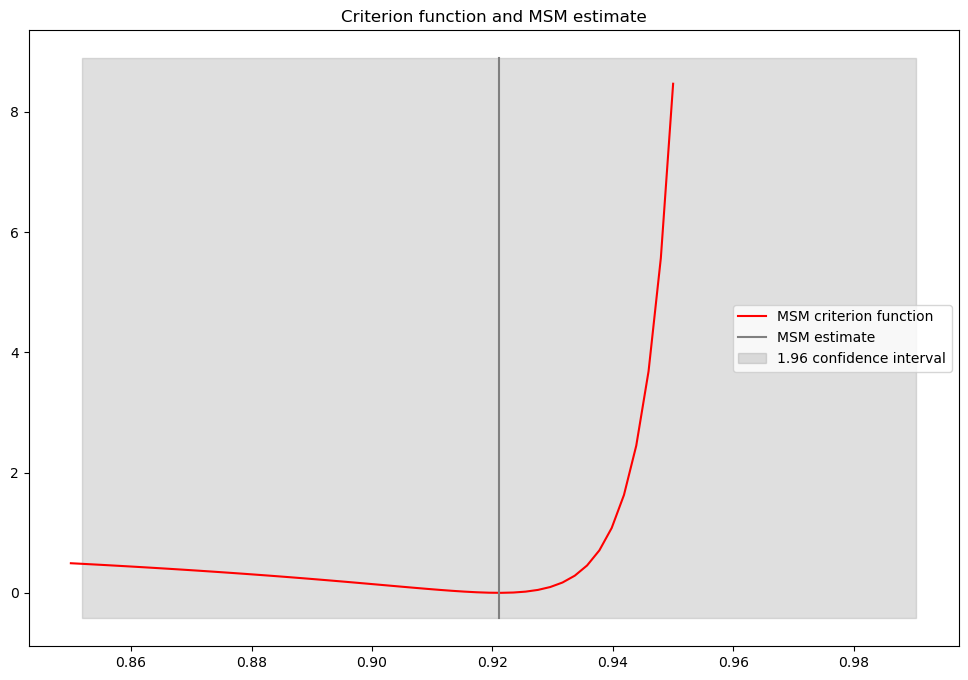

In [19]:
# Second stage MSM
moms = moment_conditions(beta_hat,data_moments_vec,seed=515)  # simulate a separate set of moment conditions
S = np.cov(np.array(moms))                                    # variance-covariance matrix of moment conditions
W1 = np.linalg.inv(S)                                         # unpdated weighting matrix
beta_hat_2 = run_MSM(W=W1)